# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import ipywidgets as widgets

slider = widgets.IntSlider(20, min=0, max=100)
slider

IntSlider(value=20)

In [3]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [47]:
import tensorflow as tf
import os

In [48]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [49]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove unwated images

In [50]:
import cv2
import imghdr

In [51]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
data_dir ="/content/drive/MyDrive/data"

In [54]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


# 3. Load Data

In [55]:
import numpy as np
from matplotlib import pyplot as plt

In [56]:
data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/data")

Found 253 files belonging to 2 classes.


In [57]:
data_iterator = data.as_numpy_iterator()

In [58]:
batch = data_iterator.next()

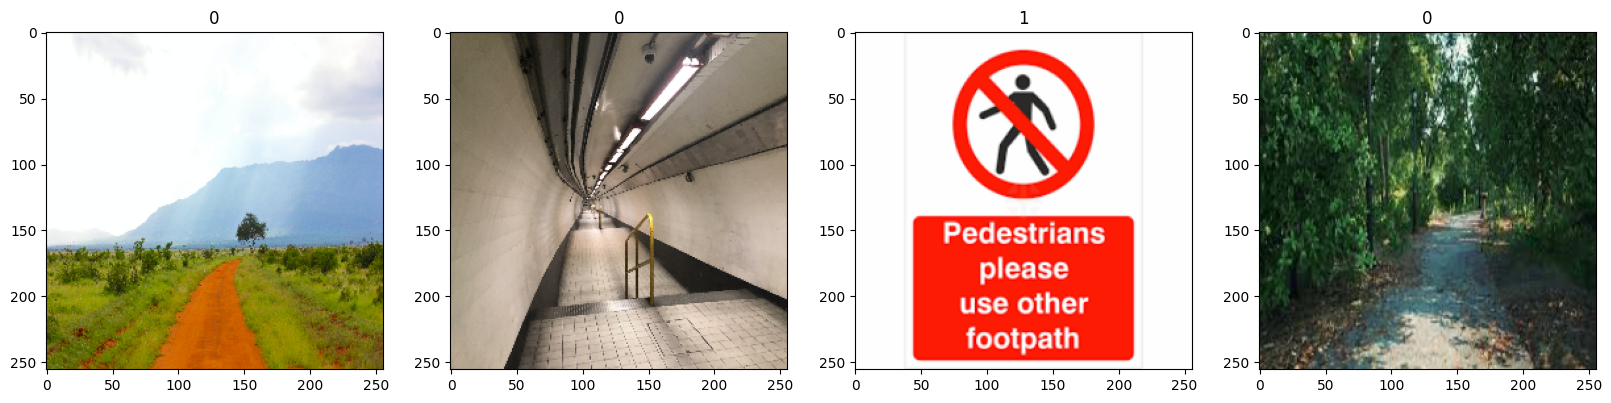

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[2.37974878e-02, 1.10071994e-01, 1.02228858e-01],
          [1.28140319e-02, 1.13059133e-01, 1.03867956e-01],
          [1.35952821e-02, 2.11236209e-01, 1.35010719e-01],
          ...,
          [3.18252146e-01, 4.11412388e-01, 1.48414522e-01],
          [7.81770825e-01, 7.74019599e-01, 4.22372848e-01],
          [8.01753998e-01, 7.82467842e-01, 4.73851115e-01]],
 
         [[1.91865806e-02, 1.17225796e-01, 1.01539522e-01],
          [4.90196107e-04, 1.29082412e-01, 9.81617644e-02],
          [3.64399523e-01, 4.92631733e-01, 2.70687819e-01],
          ...,
          [1.47005215e-01, 2.89062500e-01, 3.94071676e-02],
          [2.69270837e-01, 4.51700360e-01, 1.42348349e-01],
          [0.00000000e+00, 3.41980696e-01, 7.30392188e-02]],
 
         [[1.14889706e-04, 2.33593747e-01, 1.10071994e-01],
          [4.36634511e-01, 3.94155949e-01, 6.96920976e-02],
          [2.31617652e-02, 1.66781560e-01, 5.95205277e-02],
          ...,
          [0.00000000e+00, 1.97954968e-01, 8.5332

# 5. Split Data

In [31]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [32]:
train_size

5

In [34]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [35]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [37]:
model = Sequential()

In [38]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [41]:
logdir='logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [60]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 18s 3s/step - loss: 0.4896 - accuracy: 0.7750 - val_loss: 0.7691 - val_accuracy: 0.6250
Epoch 2/20
5/5 [==============================] - 18s 3s/step - loss: 0.5338 - accuracy: 0.7063 - val_loss: 0.4338 - val_accuracy: 0.8438
Epoch 3/20
5/5 [==============================] - 18s 3s/step - loss: 0.4019 - accuracy: 0.8500 - val_loss: 0.3673 - val_accuracy: 0.9375
Epoch 4/20
5/5 [==============================] - 18s 3s/step - loss: 0.3594 - accuracy: 0.8375 - val_loss: 0.3939 - val_accuracy: 0.9062
Epoch 5/20
5/5 [==============================] - 17s 3s/step - loss: 0.2935 - accuracy: 0.9062 - val_loss: 0.3307 - val_accuracy: 0.9062
Epoch 6/20
5/5 [==============================] - 18s 3s/step - loss: 0.2348 - accuracy: 0.9312 - val_loss: 0.1817 - val_accuracy: 0.9688
Epoch 7/20
5/5 [==============================] - 18s 3s/step - loss: 0.1967 - accuracy: 0.9438 - val_loss: 0.1016 - val_accuracy: 1.0000
Epoch 8/20
5/5 [==================

# 8. Plot Performance

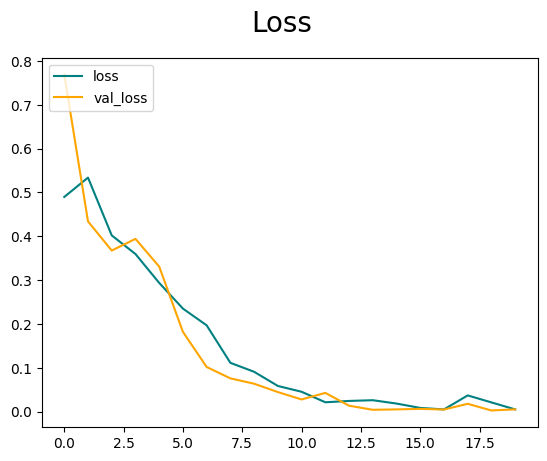

In [61]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

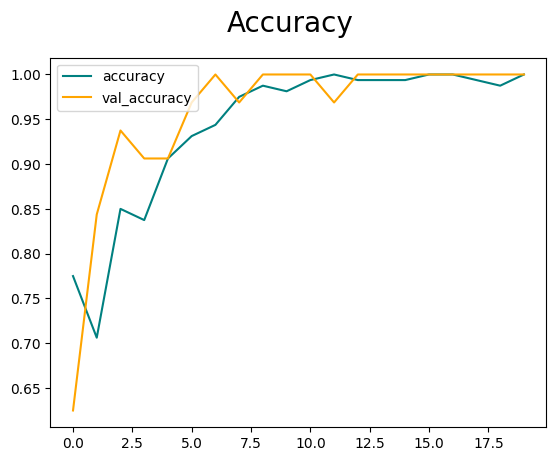

In [62]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [63]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [64]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [65]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [66]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [67]:
import cv2

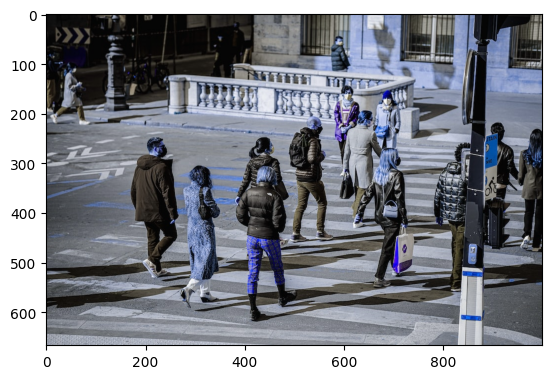

In [68]:
img = cv2.imread("/content/drive/MyDrive/pedpresent.jpeg")
plt.imshow(img)
plt.show()

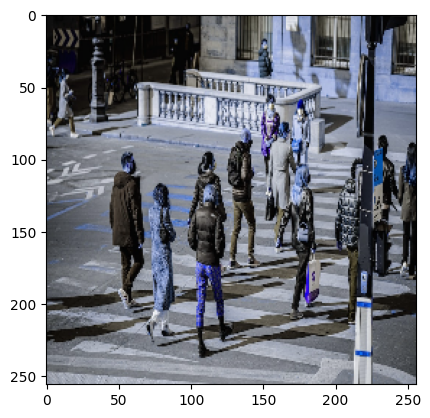

In [69]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [70]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 141ms/step


In [71]:
yhat

array([[0.9991228]], dtype=float32)

In [72]:
if yhat > 0.5:
    print(f'Predicted class is  pedestrian')
else:
    print(f'Predicted class is no  pedistrian')

Predicted class is  pedestrian


# 11. Save the Model

In [73]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))